## Project of the student Davide Ligabue, MATRICOLA: 0001191187
Exam of Deep Learning of June 2025.

# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [ ]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import os

In [ ]:
# For saving and sharing the model's weights
!pip install -U gdown
import gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
WEIGHTS_DIR = "/content/drive/MyDrive/ColabNotebooks/project_DL_2025/"

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [ ]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [ ]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [ ]:
X_train, Y_train = generate_dataset(200000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(20000)
decoder_input_val = shift_right(Y_val)

In [ ]:
i =  np.random.randint(200000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

192303
infix :  ( ( c / c ) / a )
posfix notation:  c c / a /
teacher forcing :  SOS c c / a /


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [ ]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# Instructions
If you don't want to retrain the model defined beloow you can download the pretrained weights using the cell under the paragraph **Load the weights**.

You have to uncomment and run the cell which will download the weights using gdown and the they will be loaded in the model with the function `load_weight` of the class `Seq2Seq`.

In this case be carefull to run all the notebook except for the paragraph Trining.

Otherwise if you want to retrained all the model you can run the notebook without changing anything.

# Project description

For this project i decided to start implementing the simplest encoder-decoder architecture, where both the encoder and the decoder are implemented as Recurrent Neural Networks, in particular I decided to use the Long Short-Term Memory (LSTM) for this task.

So below we can see the first two classes: `Encoder` and `Decoder` which define the encoder and the decoder respectively, and finally the class `Seq2Seq` which define our model.

Later there is also the implementation of the function `autoregressive_decode` which produce the results, token by token, using the pre-defined (and trained) model in the given test function for the final model's evaluation


In all my valutation I always keep the given parameters unchanged:


*   `VOCAB_SIZE = len(VOCAB)`,
*   `MAX_DEPTH = 3`,
*   `MAX_LEN = 30`.



---



I start running this first model using the following parameters:


*   A train set of $100000$ samples,
*   a validation set of $10000$ samples,
* as hyperparameters:
  * ` embedding_dim = 64`,
  * `lstm_units = 128`,
  * `batch_size = 256`.

I obtained a fully appreciable result with a score of 1.0 and a standard deviation of 0.0.

This result was reached after some tuning of the parameters (the last settings was reported above), and it's a strange result for a network, so logically I trained to explain my self this result thinking about the nature of this problem. It's a fully deterministic problem, where the network must learn some mathematical notions to be able to convert all the expressions, so rationally it's logical that a well-defined model reach the best score for this task.

What I could implement now so was the number of trainable parameters of my model, which now is about $200,000$.



---

The two main improvment i did was to define a new `loss_function`, based on the `SparseCategoricalCrossentropy`, which calculates the loss, masking out padding tokens, that are not relevant in our computation.

Now I'm able to reduce the number of parameters in my model, but for a better training I decided to increase the size of the train and validation dataset.

Here are the final and definitive parameters for my model:


*   A train set of $200000$ samples,
*   a validation set of $20000$ samples,
* as hyperparameters:
  * ` embedding_dim = 64`,
  * `lstm_units = 64`,
  * `batch_size = 256`.

I trained this model over 50 epochs using two important callbacks:



*   `ReduceLROnPlateau`,
*   `EarlyStopping`.

Now my model has a total number of trainable parameters of $68,943$ and it's still able to reach the perfect score:



*   `score = 1.0`,
*   `std = 0.0`.

# Define the model

In [ ]:
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = layers.LSTM(lstm_units, return_state=True)

    def call(self, inputs):
        embedded = self.embedding(inputs)
        _, state_h, state_c = self.lstm(embedded)
        return state_h, state_c

In [ ]:
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense = layers.Dense(vocab_size)

    def call(self, inputs, initial_state):
        embedded = self.embedding(inputs)
        output, state_h, state_c = self.lstm(embedded, initial_state=initial_state)
        predictions = self.dense(output)
        return predictions, state_h, state_c

In [ ]:
class Seq2Seq(Model):
    def __init__(self, encoder, decoder, weights_dir):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.weights_dir = weights_dir

    def save_path(self, model_part):
        os.makedirs(self.weights_dir, exist_ok=True)
        return os.path.join(self.weights_dir, f"{model_part}.weights.h5")

    def load_weight(self):
        self.encoder.load_weights(self.save_path('encoder'))
        self.decoder.load_weights(self.save_path('decoder'))
        print(f"Weights loaded from: {self.weights_dir}")

    def save_weight(self):
        self.encoder.save_weights(self.save_path('encoder'))
        self.decoder.save_weights(self.save_path('decoder'))
        print(f"Weights succesfully saved in: {self.weights_dir}")

    def call(self, inputs):
        encoder_input, decoder_input = inputs
        state_h, state_c = self.encoder(encoder_input)
        predictions, _, _ = self.decoder(decoder_input, initial_state=[state_h, state_c])
        return predictions

In [ ]:
def autoregressive_decode(model, encoder_input_seq):
    encoder_input_seq = tf.expand_dims(encoder_input_seq, 0)

    encoder_h, encoder_c = model.encoder(encoder_input_seq)
    decoder_states = [encoder_h, encoder_c]

    # First token to decode -> SOS token
    current_token_id = tf.constant([[SOS_ID]], dtype=tf.int32)

    results = [SOS_ID]

    for _ in range(MAX_LEN):
        # Predict the next token
        predictions, h, c = model.decoder(current_token_id, initial_state=decoder_states)
        decoder_states = [h, c]

        # Sample a token
        predicted_token = tf.argmax(predictions[0, -1, :]).numpy()

        results.append(predicted_token)

        # If the model predicts EOS -> stop generation
        if predicted_token == EOS_ID:
            break

        # Autoregressive approach -> input for the next prediction is the current predicted token
        current_token_id = tf.constant([[predicted_token]], dtype=tf.int32)

    return np.array(results)


In [ ]:
# Optimizer and Loss function
optimizer = optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, PAD_ID))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Model hyperparameters
embedding_dim = 64
lstm_units = 64

In [ ]:
encoder = Encoder(VOCAB_SIZE, embedding_dim, lstm_units)
decoder = Decoder(VOCAB_SIZE, embedding_dim, lstm_units)

In [ ]:
model = Seq2Seq(encoder, decoder, WEIGHTS_DIR)

In [ ]:
# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function)

In [ ]:
# Dummy initialization of the model
dummy_encoder_input = tf.zeros((1, MAX_LEN), dtype=tf.int32)
dummy_decoder_input = tf.zeros((1, MAX_LEN), dtype=tf.int32)

_ = model((dummy_encoder_input, dummy_decoder_input))

# Summary of the model
model.summary()

Model: "seq2_seq_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │        33,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │        34,959 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,943 (269.31 KB)

 Trainable params: 68,943 (269.31 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
# Train the model
history = model.fit(
    [X_train, decoder_input_train],
    Y_train,
    batch_size=256,
    epochs=50,
    validation_data=([X_val, decoder_input_val], Y_val),
    callbacks=callbacks
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2508 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0408 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0191 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0104 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0064 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0045 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0032 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0024 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0018 - val_loss: 0.0013 - learning_rate: 0.0010

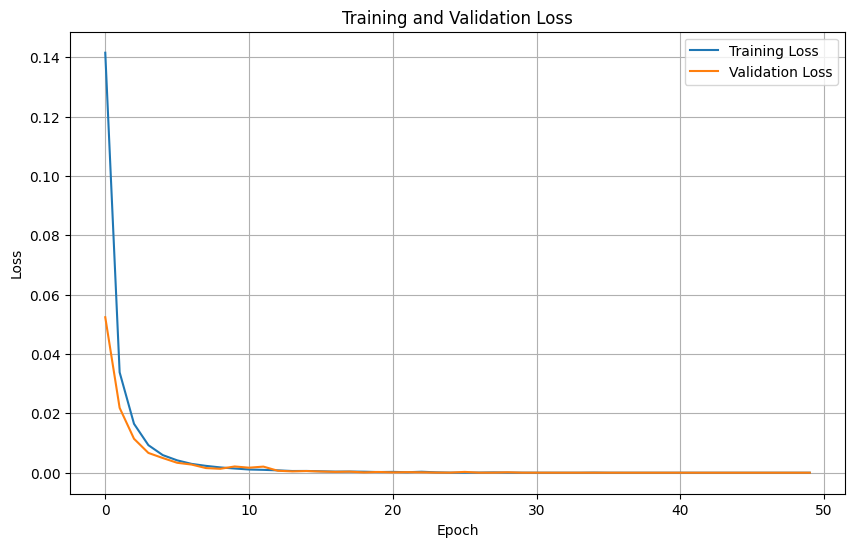

In [ ]:
# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Testing

In [ ]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

In [ ]:
# Test the model with the given test function
res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


In [ ]:
# Example translations for verification
print("\n--- Example Translations ---")
for _ in range(5):
    sample_infix_expr = generate_infix_expression(MAX_DEPTH)
    sample_infix_tokens = tokenize(sample_infix_expr)
    sample_postfix_tokens = infix_to_postfix(sample_infix_tokens)

    encoded_infix = encode(sample_infix_tokens)
    decoded_postfix_ids = autoregressive_decode(model, np.array(encoded_infix))[1:]

    print(f"INFIX: {decode_sequence(encoded_infix, id_to_token)}")
    _ = prefix_accuracy_single(encode(sample_postfix_tokens), decoded_postfix_ids, id_to_token, verbose=True)
    print("-" * 30)


--- Example Translations ---
INFIX: ( ( b + a ) + ( d / c ) )
TARGET : b a + d c / +
PREDICT: b a + d c / +
PREFIX MATCH: 7/7 → 1.00
------------------------------
INFIX: ( ( a * ( d / a ) ) + ( e * b ) )
TARGET : a d a / * e b * +
PREDICT: a d a / * e b * +
PREFIX MATCH: 9/9 → 1.00
------------------------------
INFIX: ( e - ( ( d + c ) - c ) )
TARGET : e d c + c - -
PREDICT: e d c + c - -
PREFIX MATCH: 7/7 → 1.00
------------------------------
INFIX: ( ( ( e + c ) * c ) - c )
TARGET : e c + c * c -
PREDICT: e c + c * c -
PREFIX MATCH: 7/7 → 1.00
------------------------------
INFIX: ( ( a / e ) * ( c * e ) )
TARGET : a e / c e * *
PREDICT: a e / c e * *
PREFIX MATCH: 7/7 → 1.00
------------------------------


In [ ]:
# Save the weights
model.save_weight()

Weights succesfully saved in: /content/drive/MyDrive/ColabNotebooks/project_DL_2025/


# Load the weights

In [ ]:
# Load pretrained weights instead of training
ENCODER_FILE_ID = '1MQBlQfZaCjDql3MODs6glcXzc8sZS7lT'
DECODER_FILE_ID = '1bOED86nHV7wHOmjNZMNkPgwk1hf_1Q8Q'

'''
WEIGHTS_DIR = "/content/drive/MyDrive/ColabNotebooks/project_DL_2025/"
os.makedirs(WEIGHTS_DIR, exist_ok=True)

ENCODER_PATH = os.path.join(WEIGHTS_DIR, "encoder.weights.h5")
DECODER_PATH = os.path.join(WEIGHTS_DIR, "decoder.weights.h5")

if not os.path.exists(ENCODER_PATH):
    gdown.download(id=ENCODER_FILE_ID, output=ENCODER_PATH, quiet=False)

if not os.path.exists(DECODER_PATH):
    gdown.download(id=DECODER_FILE_ID, output=DECODER_PATH, quiet=False)


# Load the weights
model.load_weight()

'''

'\nWEIGHTS_DIR = "/content/drive/MyDrive/ColabNotebooks/project_DL_2025/"\nos.makedirs(WEIGHTS_DIR, exist_ok=True)\n\nENCODER_PATH = os.path.join(WEIGHTS_DIR, "encoder.weights.h5")\nDECODER_PATH = os.path.join(WEIGHTS_DIR, "decoder.weights.h5")\n\nif not os.path.exists(ENCODER_PATH):\n    gdown.download(id=ENCODER_FILE_ID, output=ENCODER_PATH, quiet=False)\n\nif not os.path.exists(DECODER_PATH):\n    gdown.download(id=DECODER_FILE_ID, output=DECODER_PATH, quiet=False)\n\n\n# Load the weights\nmodel.load_weights()\n\n'

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.